In [14]:
#code in reference to https://www.kaggle.com/raoulma/ny-stock-price-prediction-rnn-lstm-gru

import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

# import all stock prices 
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df.info()
df.head()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])

df.tail()

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
symbol    851264 non-null object
open      851264 non-null float64
close     851264 non-null float64
low       851264 non-null float64
high      851264 non-null float64
volume    851264 non-null float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB

number of different stocks:  501
['IPG', 'ROK', 'HAR', 'AMT', 'MU', 'DE', 'WFC', 'MMC', 'JPM', 'MYL']


,symbol,open,close,low,high,volume
date,,,,,,
2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0
2016-12-30,FTV,54.200001,53.630001,53.389999,54.480000,705100.0


In [15]:
# function for min-max normalization of stock
bMax = 0
bMin = 0
def normalize_data(df):
    global bMax, bMin
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df_open = df.open.values
    beforeScalar = df.open.values.reshape(-1,1)
    bMax = np.amax(beforeScalar,0)
    bMin = np.amin(beforeScalar,0)
    
    afterScalar = min_max_scaler.fit_transform(beforeScalar)
    afterInverse = min_max_scaler.inverse_transform(afterScalar)
    
    
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    # the result of the scaler for df.open, df.high,, low, close all are all 2 dimentional, with the 2nd dimension as 1
    # and they assigning them back to df, got the orignal 2 dimension, with the 2nd dimension is 
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose one stock
df_stock = df[df.symbol == 'AAPL'].copy()
df_stock.drop(['symbol'],1,inplace=True)
df_stock.drop(['volume'],1,inplace=True)

cols = list(df_stock.columns.values)
#print('df_stock.columns.values = ', cols)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 80 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


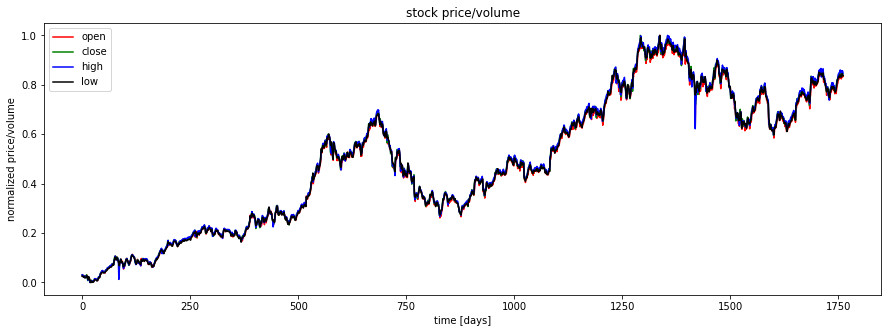

In [16]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='close')
plt.plot(df_stock_norm.low.values, color='blue', label='high')
plt.plot(df_stock_norm.high.values, color='black', label='low')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock price/volume')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [17]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;

perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)
# perm_array is just numbers 0 through 1394, random shuffled,


# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 # seq_len is 20, n_steps is 19, x/y/z_train shape is all 19 in the middle dimension
n_inputs = 4 
n_neurons = 100 # number of neurons in each layer
n_outputs = 4
n_layers = 2 # somehow using a smaller layer generates much smaller MSE
learning_rate = 0.001
n_epochs = 20 # number of times we'll feed the data set through
batch_size = 50 # the trainiging data first dimension 1394 is still too big, so break it down to batches, each has 50 (out of 1394)
train_set_size = x_train.shape[0] # 1394
test_set_size = x_test.shape[0]

tf.reset_default_graph()

# tensor for input, (?, 19, 4)
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
# tensor for output, (?, 4)
y = tf.placeholder(tf.float32, [None, n_outputs])

# LSTM Cell 
# given n_layers = 4, this basically call  tf.contrib.rnn.BasicLSTMCell 4 times
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]
print('layers', layers)
# each layer has the configurtion of n_neurons cells, or 100 cells, and cell type is BasicLSTMCell.
# and put the result in the layers array,

# tf.nn.elu, Computes exponential linear: exp(features) - 1 if < 0, features otherwise

# now using the layer configuration, really create the cells network
# 4 layers, each has 100 cells of type BasicLSTMCell
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)

# now really creates a recurrent neural network, using the configuration
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
print('rnn_outputs, states', rnn_outputs, states) # (? 19, 100)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
print('stacked_rnn_outputs', stacked_rnn_outputs) # (?, 100)

# A dense layer is just a regular layer of neurons in a neural network,
# each neuron recieves input from all the neurons in the previous layer, thus densely connected
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
print('stacked_outputs', stacked_outputs) # (?, 4)

outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
#print('outputs', outputs) # (?, 19, 4)
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
print('outputs', outputs) # (?, 4)

loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
# Adam optimization algorithm is an extension to stochastic gradient descent
training_op = optimizer.minimize(loss)
# actual operation, optimize for minimal mean square error, run by tensor flow later
                                              
# run graph
# session is a like process, the run time
print('total iterations', int(n_epochs*train_set_size/batch_size))
# will iterate through that many items through the RNN, each time feet batch size data
with tf.Session() as sess: 
   sess.run(tf.global_variables_initializer())
   for iteration in range(int(n_epochs*train_set_size/batch_size)): # 100 * 1394 / 50 iterations
       x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch
       # run the session, or the tensor flow, fee the 2 tesors X & Y with data x_batch & y _batch
       sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
       # every 5 * 1394 / 50 = 139 iterations, we print out something, so we know it is going on
       if iteration % int(1*train_set_size/batch_size) == 0:
           # print out the loss, should get smaller and smaller
           mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
           mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
           # print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
           #    iteration*batch_size/train_set_size, mse_train, mse_valid))
           print('%d iterations: MSE train/valid = %.6f/%.6f'%(
               iteration, mse_train, mse_valid))

   
   y_train_pred = sess.run(outputs, feed_dict={X: x_train})
   y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
   y_test_pred = sess.run(outputs, feed_dict={X: x_test})


aMaxTrainPred = np.amax(y_train_pred[:,3])
aMinTrainPred = np.amin(y_train_pred[:,3])
aMaxTrain = np.amax(y_train[:,3])
aMinTrain = np.amin(y_train[:,3])
aMaxTestPred = np.amax(y_test_pred[:,3])
aMinTestPred = np.amin(y_test_pred[:,3])
aMaxTest = np.amax(y_test[:,3])
aMinTest = np.amin(y_test[:,3])




layers [<tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell object at 0x1a39281e10>, <tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell object at 0x1a39281ef0>]
rnn_outputs, states Tensor("rnn/transpose_1:0", shape=(?, 79, 100), dtype=float32) (LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 100) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 100) dtype=float32>))
stacked_rnn_outputs Tensor("Reshape:0", shape=(?, 100), dtype=float32)
stacked_outputs Tensor("dense/BiasAdd:0", shape=(?, 4), dtype=float32)
outputs Tensor("strided_slice:0", shape=(?, 4), dtype=float32)
total iterations 538
0 iterations: MSE train/valid = 0.128818/0.284623
26 iterations: MSE train/valid = 0.001988/0.003859
52 iterations: MSE train/valid = 0.000818/0.001699
78 iterations: MSE train/valid = 0.000747/0.001476
104 iterations: MSE train/valid = 0

In [18]:
#Process for unnormalizing the prices
for i in range(0,y_train.shape[0]):
    for j in range(0,4):
        x = y_train[i,j]
        val = (x - aMinTrain)*(bMax-bMin)/(aMaxTrain-aMinTrain) + bMin
        y_train[i,j] = val


y_train_close = y_train[:,1]



for i in range(0,y_train_pred.shape[0]):
    for j in range(0,4):
        x = y_train_pred[i,j]
        val = (x - aMinTrainPred)*(bMax-bMin)/(aMaxTrainPred-aMinTrainPred) + bMin
        y_train_pred[i,j] = val


y_pred_close = y_train_pred[:,1]


y_diff = y_pred_close - y_train_close 


for i in range(0,y_test.shape[0]):
    for j in range(0,4):
        x = y_test[i,j]
        val = (x - aMinTest)*(bMax-bMin)/(aMaxTest-aMinTest) + bMin
        y_test[i,j] = val


for i in range(0,y_test_pred.shape[0]):
    for j in range(0,4):
        x = y_test_pred[i,j]
        val = (x - aMinTestPred)*(bMax-bMin)/(aMaxTestPred-aMinTestPred) + bMin
        y_test_pred[i,j] = val


fig2, box2 = plt.subplots()
box2.set_title("box plot for diff")
box2.boxplot(y_diff, positions = [1])


{'boxes': [<matplotlib.lines.Line2D at 0x1a401f3898>],
 'caps': [<matplotlib.lines.Line2D at 0x1a4020f2e8>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a4020fcc0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a4020f978>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1a401f3ba8>,
  <matplotlib.lines.Line2D at 0x1a401f3f60>]}

In [19]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest


plt.figure(figsize=(20, 5));


plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('Future Stock Prices',fontsize=20, fontweight='bold')
plt.xlabel('Time in Days',fontsize=20, fontweight='bold')
plt.ylabel('Price in USD',fontsize=20, fontweight='bold')
plt.legend(loc='best',prop={"size":15});

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))

correct sign prediction for close - open price for train/valid/test: 0.75/0.78/0.89


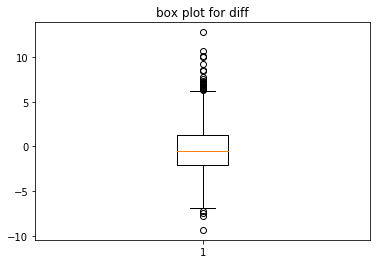

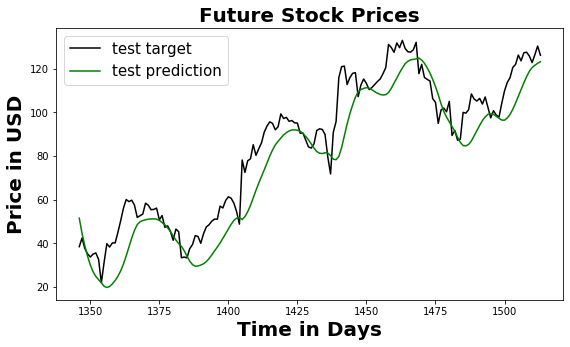

In [20]:
plt.show()

In [21]:
# function for min-max normalization of stock
bMax = 0
bMin = 0
def normalize_data(df):
    global bMax, bMin
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df_open = df.open.values
    beforeScalar = df.open.values.reshape(-1,1)
    bMax = np.amax(beforeScalar,0)
    bMin = np.amin(beforeScalar,0)
    
    afterScalar = min_max_scaler.fit_transform(beforeScalar)
    afterInverse = min_max_scaler.inverse_transform(afterScalar)

    
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    # the result of the scaler for df.open, df.high,, low, close all are all 2 dimentional, with the 2nd dimension as 1
    # and they assigning them back to df, got the orignal 2 dimension, with the 2nd dimension is 
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        # each element of the data is a sequence of stock trading data rows, length is seq_len
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    print('data dimension', data.shape)
    print('print out the first 2 rows of data, each is a sequence of normalize stock data, each stock data has open/close/low/high')
    print(data[:2])
    # data.shape[0] is 1762, take 10% of the rows
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    print('spliting valid test train', valid_set_size, test_set_size, train_set_size)
    
    # 1st dimension, take the train set size, 2nd dimension of 20, take 19, [:-1] in python is beginng to last but 1
    x_train = data[:train_set_size,:-1,:]
    # 1st dimension, take the train set size, 2nd dimension of 20, take the last, [-1] means the last
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# choose multiple stocks
df_stock = df[df.symbol == 'AAPL'].copy() # choosing target stock
df_stock1 = df[df.symbol == 'MSFT'].copy() #choosing relevant stock 1
df_stock2 = df[df.symbol == 'INTC'].copy() #choosing relevant stock 2
df_stock3 = df[df.symbol == 'NFLX'].copy() #choosing relevant stock 3
df_stock4 = df[df.symbol == 'HPQ'].copy() #choosing relevant stock 4
df_stock.drop(['symbol'],1,inplace=True) # drop column symbol, it is all apple
df_stock.drop(['volume'],1,inplace=True) # drop column volume, not using in, open predict prices, not volume
df_stock1.drop(['symbol'],1,inplace=True) # drop column symbol, it is all apple
df_stock1.drop(['volume'],1,inplace=True) # drop column volume, not using in, open predict prices, not volume
df_stock2.drop(['symbol'],1,inplace=True) # drop column symbol, it is all apple
df_stock2.drop(['volume'],1,inplace=True) # drop column volume, not using in, open predict prices, not volume
df_stock3.drop(['symbol'],1,inplace=True) # drop column symbol, it is all apple
df_stock3.drop(['volume'],1,inplace=True) # drop column volume, not using in, open predict prices, not volume
df_stock4.drop(['symbol'],1,inplace=True) # drop column symbol, it is all apple
df_stock4.drop(['volume'],1,inplace=True) # drop column volume, not using in, open predict prices, not volume
df_stock.info()

cols = list(df_stock.columns.values)

# normalize stock
df_stock_norm = df_stock.copy()
df_stock_1norm = df_stock1.copy()
df_stock_2norm = df_stock2.copy()
df_stock_3norm = df_stock3.copy()
df_stock_4norm = df_stock4.copy()





df_stock_norm = normalize_data(df_stock_norm)

df_stock_1norm = normalize_data(df_stock_1norm)
df_stock_2norm = normalize_data(df_stock_2norm)
df_stock_3norm = normalize_data(df_stock_3norm)
df_stock_4norm = normalize_data(df_stock_4norm)


#weighting
df_stock_1norm = df_stock_1norm * 0.3909 #correlation for relevant stock 1
df_stock_2norm = df_stock_2norm * 0.1624 #correlation for relevant stock 2

df_stock_3norm = df_stock_3norm * 0.0563 #correlation for relevant stock 3
df_stock_4norm = df_stock_4norm * 0.3191 #correlation for relevant stock 4


df_stock_norm = df_stock_norm.add(df_stock_1norm)
df_stock_norm = df_stock_norm.add(df_stock_2norm)
df_stock_norm = df_stock_norm.add(df_stock_3norm)
df_stock_norm = df_stock_norm.add(df_stock_4norm)

df_stockNew = df[df.symbol == 'AAPL'].copy()
df_stockNew.drop(['symbol'],1,inplace=True) # drop column symbol, it is all apple
df_stockNew.drop(['volume'],1,inplace=True) # drop column volume, not using in, open predict prices, not volume
df_stock_normNew = df_stockNew.copy()
df_stock_normNew = normalize_data(df_stock_normNew)


# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
x1_train, y1_train, x1_valid, y1_valid, x1_test, y1_test = load_data(df_stock_normNew, seq_len)

x_valid = x1_valid
y_valid = y1_valid
x_test = x1_test
y_test = y1_test


# print the dimension of the data for comparison

df_stock.head(5)
df_stock_norm.head(5) # normalized, or really scaled to to between -1 and 1

<class 'pandas.core.frame.DataFrame'>
Index: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 4 columns):
open     1762 non-null float64
close    1762 non-null float64
low      1762 non-null float64
high     1762 non-null float64
dtypes: float64(4)
memory usage: 68.8+ KB
data dimension (1742, 20, 4)
print out the first 2 rows of data, each is a sequence of normalize stock data, each stock data has open/close/low/high
[[[0.4231522  0.43561541 0.43060028 0.42672286]
  [0.43248912 0.43764485 0.43693115 0.42952471]
  [0.43423866 0.42710997 0.43250782 0.42830585]
  [0.42530916 0.42200153 0.4241173  0.41797277]
  [0.41772036 0.43071121 0.42531753 0.42109839]
  [0.43339998 0.42418332 0.42604379 0.42393554]
  [0.41711071 0.41283654 0.41656334 0.41291717]
  [0.41652013 0.42424569 0.41382606 0.41600833]
  [0.42328251 0.43456872 0.4313117  0.42855392]
  [0.43657161 0.4231636  0.42853622 0.42948472]
  [0.42235564 0.44189264 0.43107018 0.43201173]
  [0.43364226 0.4287202  0.42603321 0.426

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


,open,close,low,high
date,,,,
2010-01-04,0.423152,0.435615,0.430600,0.426723
2010-01-05,0.432489,0.437645,0.436931,0.429525
2010-01-06,0.434239,0.427110,0.432508,0.428306
2010-01-07,0.425309,0.422002,0.424117,0.417973
2010-01-08,0.417720,0.430711,0.425318,0.421098


In [22]:
## Basic Cell RNN in tensorflow


index_in_epoch = 0;

perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)
# perm_array is just numbers 0 through 1394, random shuffled,


# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 # seq_len is 20, n_steps is 19, x/y/z_train shape is all 19 in the middle dimension
n_inputs = 4 
n_neurons = 100 # number of neurons in each layer
n_outputs = 4
n_layers = 2 # somehow using a smaller layer generates much smaller MSE
learning_rate = 0.001
n_epochs = 20 # number of times we'll feed the data set through
batch_size = 50 # the trainiging data first dimension 1394 is still too big, so break it down to batches, each has 50 (out of 1394)

train_set_size = x_train.shape[0] # 1394
test_set_size = x_test.shape[0]

tf.reset_default_graph()

# tensor for input, (?, 19, 4)
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
# tensor for output, (?, 4)
y = tf.placeholder(tf.float32, [None, n_outputs])

# LSTM Cell 
# given n_layers = 4, this basically call  tf.contrib.rnn.BasicLSTMCell 4 times
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]
print('layers', layers)
# each layer has the configurtion of n_neurons cells, or 100 cells, and cell type is BasicLSTMCell.
# and put the result in the layers array,


# now using the layer configuration, really create the cells network
# 4 layers, each has 100 cells of type BasicLSTMCell
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)

# now really creates a recurrent neural network, using the configuration
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
print('rnn_outputs, states', rnn_outputs, states) # (? 19, 100)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
print('stacked_rnn_outputs', stacked_rnn_outputs) # (?, 100)

# A dense layer is just a regular layer of neurons in a neural network,
# each neuron recieves input from all the neurons in the previous layer, thus densely connected
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
print('stacked_outputs', stacked_outputs) # (?, 4)

outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
print('outputs', outputs) # (?, 19, 4)
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
print('outputs', outputs) # (?, 4)

loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
# Adam optimization algorithm is an extension to stochastic gradient descent
training_op = optimizer.minimize(loss)
# actual operation, optimize for minimal mean square error, run by tensor flow later
                                              
# run graph
# session is a like process, the run time
print('total iterations', int(n_epochs*train_set_size/batch_size))
# will iterate through that many items through the RNN, each time feet batch size data
with tf.Session() as sess: 
   sess.run(tf.global_variables_initializer())
   for iteration in range(int(n_epochs*train_set_size/batch_size)): # 100 * 1394 / 50 iterations
       x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch
       # run the session, or the tensor flow, fee the 2 tesors X & Y with data x_batch & y _batch
       sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
       # every 5 * 1394 / 50 = 139 iterations, we print out something, so we know it is going on
       if iteration % int(1*train_set_size/batch_size) == 0:
           # print out the loss, should get smaller and smaller
           mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
           mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
           # print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
           #    iteration*batch_size/train_set_size, mse_train, mse_valid))
           print('%d iterations: MSE train/valid = %.6f/%.6f'%(
               iteration, mse_train, mse_valid))

   
   y_train_pred = sess.run(outputs, feed_dict={X: x_train})
   y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
   y_test_pred = sess.run(outputs, feed_dict={X: x_test})



aMaxTrainPred = np.amax(y_train_pred[:,3])
aMinTrainPred = np.amin(y_train_pred[:,3])
aMaxTrain = np.amax(y_train[:,3])
aMinTrain = np.amin(y_train[:,3])
aMaxTestPred = np.amax(y_test_pred[:,3])
aMinTestPred = np.amin(y_test_pred[:,3])
aMaxTest = np.amax(y_test[:,3])
aMinTest = np.amin(y_test[:,3])




layers [<tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell object at 0x1a3d1f4518>, <tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell object at 0x1a3d1f40b8>]
rnn_outputs, states Tensor("rnn/transpose_1:0", shape=(?, 19, 100), dtype=float32) (LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 100) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_6:0' shape=(?, 100) dtype=float32>))
stacked_rnn_outputs Tensor("Reshape:0", shape=(?, 100), dtype=float32)
stacked_outputs Tensor("dense/BiasAdd:0", shape=(?, 4), dtype=float32)
outputs Tensor("Reshape_1:0", shape=(?, 19, 4), dtype=float32)
outputs Tensor("strided_slice:0", shape=(?, 4), dtype=float32)
total iterations 557
0 iterations: MSE train/valid = 0.498968/0.423182
27 iterations: MSE train/valid = 0.006030/0.004478
54 iterations: MSE train/valid = 0.002066/0.001760
81 iterations: MSE trai

In [23]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(30, 5));


plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('Future Stock Prices',fontsize=20, fontweight='bold')
plt.xlabel('Time in Days',fontsize=20, fontweight='bold')
plt.ylabel('Price in USD',fontsize=20, fontweight='bold')
plt.legend(loc='best',prop={"size":15});

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))

correct sign prediction for close - open price for train/valid/test: 0.72/0.78/0.89


In [24]:
#Process for unnormalizing the values 
for i in range(0,y_train.shape[0]):
    for j in range(0,4):
        x = y_train[i,j]
        val = (x - aMinTrain)*(bMax-bMin)/(aMaxTrain-aMinTrain) + bMin
        y_train[i,j] = val


y_train_close = y_train[:,1]



for i in range(0,y_train_pred.shape[0]):

    for j in range(0,4):
        x = y_train_pred[i,j]
        val = (x - aMinTrainPred)*(bMax-bMin)/(aMaxTrainPred-aMinTrainPred) + bMin
        y_train_pred[i,j] = val


y_pred_close = y_train_pred[:,1]


y_diff2 = y_pred_close - y_train_close 



for i in range(0,y_test.shape[0]):
    for j in range(0,4):
        x = y_test[i,j]
        val = (x - aMinTest)*(bMax-bMin)/(aMaxTest-aMinTest) + bMin
        y_test[i,j] = val


for i in range(0,y_test_pred.shape[0]):
    for j in range(0,4):
        x = y_test_pred[i,j]
        val = (x - aMinTestPred)*(bMax-bMin)/(aMaxTestPred-aMinTestPred) + bMin
        y_test_pred[i,j] = val




In [25]:

plt.figure(figsize = (15,15))

fig2, box2 = plt.subplots()
fig2.subplots_adjust(left=0.075, right=2, top=2, bottom=0)
box2.set_title("Box Plot Comparison of two Methods for Target Deviations ", fontsize=20)
box2.boxplot(y_diff, positions = [1], notch = True)
box2.boxplot(y_diff2, positions = [2], notch = True)
box2.set_ylabel('Difference between Predicton and Real Values (USD)', fontsize = 20)
plt.xticks([1,2], ['Single Stock Prediction for AAPL ', 'Multi Stock Prediction for AAPL'], fontsize=20)
plt.figure(figsize = (15,15))


<Figure size 1080x1080 with 0 Axes>

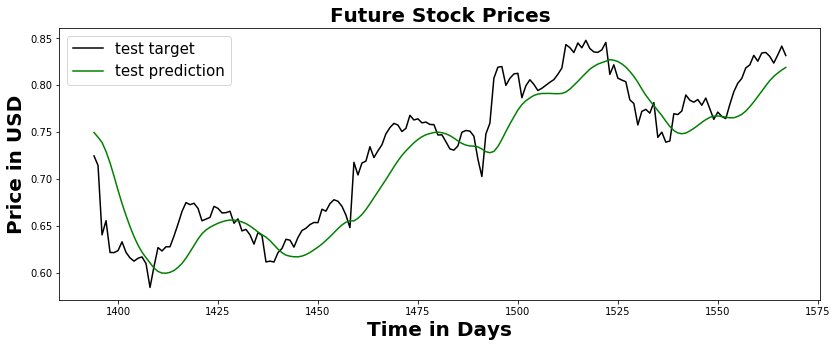

<Figure size 1080x1080 with 0 Axes>

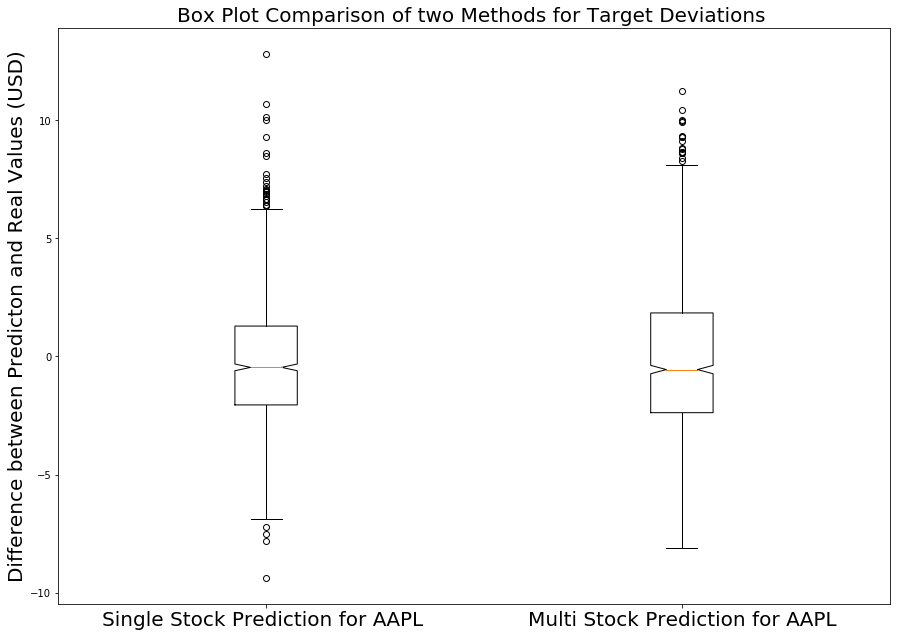

<Figure size 1080x1080 with 0 Axes>

In [26]:
plt.show()